# **Configuration**

In [1]:
#=========== Configure the notebook =========#
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import genfromtxt
import random
import math
import matplotlib.pyplot as plt
!pip install gekko
from gekko import GEKKO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 55.1 MB/s eta 0:00:00


# **Transmission parameters**

In [3]:
global nbit
nbit=1 # number of bits per symbol

global OvrSmpRatio
OvrSmpRatio=8 # oversampling ratio

T_symb_des=.5 #symbol duration

global Ts
Ts=T_symb_des/OvrSmpRatio #sample time

AveTxPow = 1
global NoiseVar
SNR = 50
NoiseVar = 10 ** ((-SNR ) / 10)

guard_length = 10
nsymb=100 +guard_length # number of input symbols
N=nbit*nsymb # length of bit sequence
batch_size=40

global in_features
in_features = N

# **Generate symbols**

In [4]:
#=========== generate data  =========#
def generate_data(N,batch_size):
    for b in range(batch_size):
        if b>0:
            h2=np.append(h2,np.random.binomial(size=N, n=1, p= 0.5).reshape((1,1,-1)),axis=0)
        else:
            h2=np.random.binomial(size=N, n=1, p= 0.5).reshape((1,1,-1))
    return torch.from_numpy(h2).float()

def generate_data_uniform(N,batch_size):
    for b in range(batch_size):
        if b>0:
            h2=np.append(h2,np.random.uniform(size=N, low=-1.0, high=1.0).reshape((1,1,-1)),axis=0)
        else:
            h2=np.random.uniform(size=N, low=-1.0, high=1.0).reshape((1,1,-1))
    return torch.from_numpy(h2).float()


## **Real world MC channel model**

In [5]:
def f_MC(t):
  # continuous time impulse response
  global D
  global v
  global d
  global k
  if t==0.0:
    return 0.0
  return k/(np.sqrt(4*D*t))*np.e**(-(d-v*t)**2/(4*D*t))

def vary_params(strength=0): #default parameters vary by 68 percent on average
#rule for parameter-variation
  D_0= 1.24*10**(-4)  #diffusion coef
  v_0= 0.055    # flow velocity
  k_0= 0.0000001     # gain
  d_0= 0.036    # distance to electrodes
  global D
  D=D_0+np.random.uniform(0,1)*D_0*strength
  global v
  v=v_0+np.random.uniform(0,1)*v_0*strength
  global k
  k=k_0+np.random.uniform(0,1)*k_0*strength
  global d
  d=d_0

# **Real world system generation**

In [6]:
class real_sys:
  def __init__(self,f,Ts,vary_params,oversampling_ratio, treshold=0.0000001, noise_var=0.0000000000001):
    '''
    Receives function f(t) to be evaluated at time-steps Ts
    '''
    self.Ts=Ts
    self.f=f
    self.oversampling_ratio=oversampling_ratio
    self.treshold=treshold ## the value from which on a filter coefficient is neglected
    self.noise_var=noise_var
    self.vary_params=vary_params

  def run(self,u,vary=True,shift=0):
    '''
    Computes simulation output for current impulse response (might change between executions)
    '''
    delta=10
    u=np.repeat(u,self.oversampling_ratio)
    T=self.Ts/self.oversampling_ratio
    t=0
    kernel=[]
    prev=0
    if vary==True:
      vary_params()
    while delta>self.treshold: # idea is that imp-resp first raises and then decays to zero. If close to zero finish kernel-coef calc
      kernel.append(self.f(t))
      t+=T
      if prev>kernel[-1]:
        delta=kernel[-1] # measure size of coefficien
      prev=kernel[-1]
    kernel=np.array(kernel)
    out=np.convolve(kernel,u)
    out=out[::self.oversampling_ratio]
    out=out[shift:]
    return out

  def run_torch(self,u,vary=True,shift=0):
    '''
    Computes simulation output for current impulse response (might change between executions)
    '''
    delta=10
    T=Ts
    t=0
    kernel=[]
    prev=0
    if True:
      vary_params()
    while delta>self.treshold: # idea is that imp-resp first raises and then decays to zero. If close to zero finish kernel-coef calc
      kernel.append(f_MC(t))
      t+=T
      if prev>kernel[-1]:
        delta=kernel[-1] # measure size of coefficien
      prev=kernel[-1]
    kernel=kernel/max(kernel)
    kernel=np.array(kernel)
    kernel=torch.reshape(torch.from_numpy(kernel),(1,1,-1)).float()

    out=torch.nn.functional.conv1d(u,torch.flip(kernel,(2,)),padding=kernel.shape[2])

    return out

  def Ch_Coefs(self,length):
    D_0=1.24*10**(-4)  #diffusion coef
    v_0=0.055    # flow velocity
    k_0=0.0000001     # gain
    L=0.036    # distance to electrodes
    l=[0]
    for i in range(length):
      t=Ts*(i+1)
      l.append(k_0/np.sqrt(4*math.pi*D*t)*math.e**(-(L-v*t)**2/(4*D*t)))
    l=(l/max(l))
    coefs=l
    return coefs

# **ARX channel model estimation**

In [7]:
class FIR:
  def __init__(self,b,a,K):
    self.K=K
    self.b=torch.from_numpy(b).reshape(1,1,-1).float()
    self.b.requires_grad_(False)
  def run(self,u,L):
    u=torch.reshape(u,(u.shape[0],1,u.shape[1]))
    return torch.nn.functional.conv1d(u, self.b,padding='same')

class IIR:
    def __init__(self,b,a,c,K):
      self.a=a
      self.b=b
      self.c=c
      self.K=K
      self.model=self.make_model()

    def make_model(self):
      #here stuff becomes strange since gekko outputs a as 2d, b as 3d and c as 1d array
      dim1=self.a.shape[0]
      nb=self.b.shape[1]
      A=np.concatenate((np.zeros((dim1-1,1)),np.identity(dim1-1)),axis=1)
      A=np.concatenate((A,np.flip(self.a.T)),axis=0)
      A1=np.concatenate((A,np.zeros(A.shape)),axis=1)
      A2=np.concatenate((np.zeros(A.shape),A),axis=1)
      A=np.concatenate((A1,A2))
      A=torch.from_numpy(A)
      A=torch.nn.Parameter(A.float())
      B1=np.zeros((2*dim1,1))
      B1[dim1-1,0]=1
      B1=torch.from_numpy(B1)
      B1=torch.nn.Parameter(B1.float())
      B2=np.zeros((2*dim1,1))
      B2[-1,0]=1
      B2=torch.from_numpy(B2)
      B2=torch.nn.Parameter(B2.float())
      print(self.K)
      C=np.concatenate((np.zeros((1,dim1-nb)),np.flip(self.b[0,:,:].T),np.zeros((1,dim1))),axis=1)
      C[0,dim1]=self.c[0]
      C=torch.from_numpy(C)
      C=torch.nn.Parameter(C.float())
      return IIR_nn(A,B1,B2,C)


    def run(self,u,L):
      return self.model.run(u,L)


class IIR_nn(torch.nn.Module):
    def __init__(self,A,B1,B2,C):
        super(IIR_nn, self).__init__()
        self.dx=A.shape[0] #dimension of hidden space
        self.LB1=torch.nn.Linear(1,A.shape[1],bias=False)
        self.LB1.weight=B1
        self.LB1.requires_grad_(False)
        self.LB2=torch.nn.Linear(1,A.shape[1],bias=False)
        self.LB2.weight=B2
        self.LB2.requires_grad_(False)
        self.LA=torch.nn.Linear(A.shape[1],A.shape[1],bias=False)
        self.LA.weight=A
        self.LA.requires_grad_(False)
        self.LC=torch.nn.Linear(A.shape[1],1,bias=False)
        self.LC.weight=C
        self.LC.requires_grad_(False)

    def run(self,u,L):
      #expects an input of form (N_in,batch_size,1)
      #assumes zero input befor and after transmission
      x=torch.zeros((u.shape[1]),self.dx)
      x.requires_grad_(False)
      out=0
      for i in range(L):
        if i<u.shape[0]:
          inp=u[i,:,:]
        else:
          inp=torch.zeros(u[0,:,:].shape).float()
        y=self.LC(x)
        x=self.LA(x)+self.LB1(inp)+self.LB2(torch.randn_like(inp))
        if i==0:
          out=y.reshape((1,y.shape[0],y.shape[1]))
        else:
          out=torch.concatenate((out,y.reshape((1,y.shape[0],y.shape[1]))))
      out=torch.permute(out, (1, 2, 0))
      return out


class sys:
  def __init__(self, na,nb, nk, Ts, L):
    if (na>1 and na<nb):
      raise Exception("Only causal IIR (nb<=na) or FIR (na=1) allowed")
    self.na=na #number of denominator coefficients
    self.nb=nb # number of nominator coefficients
    self.nk=nk # dead time
    self.Ts=Ts
    self.m=GEKKO()
    self.model=None
    self.L=L #length of response (for IIR)

  def estimate(self,y,u):
    l=int(len(u))
    t=np.linspace(0,(l-1)*self.Ts,l)
    yp,p,K = self.m.sysid(t,u,y,self.na,self.nb,nk=self.nk,pred='meas')
    return p,K

  def build_differentiable_model(self,y,u):
    p,K=self.estimate(y,u)
    if self.na<1:
      raise Exception('Invalid na')
    if self.na==1:
      self.model= FIR(p["b"],p["a"],K)
    else:
      self.model=IIR(p["b"],p["a"],p["c"],K)

  def run(self,u):
    #print(u.shape)
    if self.model==None:
      raise Exception('You first have to estimate a system. Use sys.build_differentiable_model(y,u)')
    else:
      if self.na<=1:
        o=self.model.run(u,self.L)
      else:
        u=torch.permute(u,(1,0))
        u=torch.reshape(u,(u.shape[0],u.shape[1],1))
        o=self.model.run(u,self.L)
      return o

## **ARX approach to generate model for the channel**

[[1.08155003]]


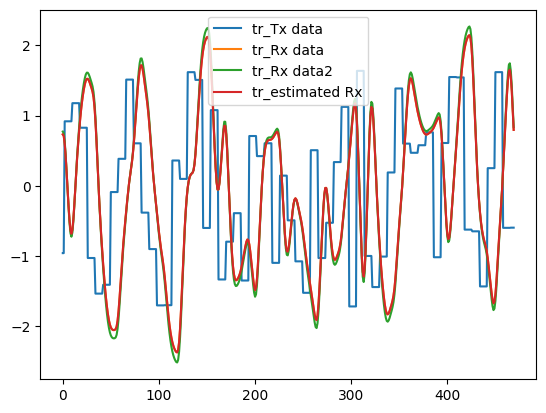

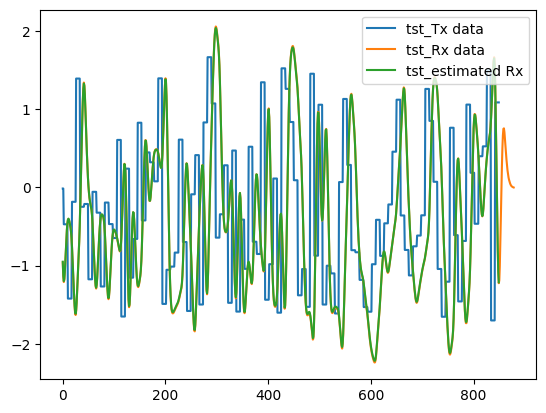

In [9]:
#============== real system data gathering ================#
#-- random data generation
u=generate_data_uniform(nsymb,batch_size)
ups = nn.Upsample(scale_factor=OvrSmpRatio, mode='nearest')
u = ups(u)

#-- real system run (1)
MC_obj = real_sys(f_MC,Ts,vary_params,OvrSmpRatio)
y1 = MC_obj.run_torch(u,vary=True)
y=y1[:,:,:u.shape[2]]


#-- real system run (2) <--- FIR channel
coefs = MC_obj.Ch_Coefs(length=121)
coefs = torch.reshape(torch.from_numpy(coefs),(1,1,-1)).float()
y2 = torch.nn.functional.conv1d(u, torch.flip(coefs,(2,)),padding=coefs.shape[2])


#============== ARX model genration ================#
#-- build ARX model (IIR)
id_MC=sys(15,8,2,Ts,L=OvrSmpRatio*nsymb)

model=id_MC.build_differentiable_model(y[0,0,:].detach().numpy(),u[0,0,:].detach().numpy()) #requires only 1-D dataset
resp=id_MC.run(u[:,0,:])


#-- Normalize outputs
u=torch.div(u, torch.sqrt(torch.mean(torch.pow(u,2))))
y=torch.div(y, torch.sqrt(torch.mean(torch.pow(y,2))))
y2=torch.div(y2, torch.sqrt(torch.mean(torch.pow(y2,2))))
resp=torch.div(resp, torch.sqrt(torch.mean(torch.pow(resp,2))))

#-- Plot training figures
plt.figure()
plt.plot(u[0,0,30:500])
plt.plot(y[0,0,30:500])
plt.plot(y2[0,0,30:500])
plt.plot(resp[0,0,30:500])
plt.legend(['tr_Tx data','tr_Rx data','tr_Rx data2','tr_estimated Rx'])


#============== ARX model test ================#
#-- random data generation
u_test=generate_data_uniform(nsymb,batch_size)
u_test = ups(u_test)

#-- real system run (1)
y_test=MC_obj.run_torch(u_test,vary=True)


#-- ARX model (IIR) test
resp_test=id_MC.run(u_test[:,0,:])

#-- Normalization
u_test=torch.div(u_test, torch.sqrt(torch.mean(torch.pow(u_test,2))))
y_test=torch.div(y_test, torch.sqrt(torch.mean(torch.pow(y_test,2))))
resp_test=torch.div(resp_test, torch.sqrt(torch.mean(torch.pow(resp_test,2))))

#-- Plot test figures
plt.figure()
plt.plot(u_test[0,0,30:1000:])
plt.plot(y_test[0,0,30:1000])
plt.plot(resp_test[0,0,30:1000])
plt.legend(['tst_Tx data','tst_Rx data','tst_estimated Rx'])

### ***Define AEC network***

In [11]:
#=========== define Class FIR network =========#
class AEC_net(nn.Module):

    def __init__(self,in_features, hidden_features, OverSamplingRatio):
        super(AEC_net, self).__init__()

        ##---- Input and output size
        self.in_features=in_features
        self.hidden_features=hidden_features
        self.out_features=self.in_features

        ch1 = 16
        ch2 = 32
        kernel1 = 3 #nbit
        kernel2 = 7 #mem_ch
        kernel3 = 5
        mem_ch = 11

        #---Encoder layers
        self.l1=torch.nn.Conv1d(1, ch1, kernel1, padding='same')
        self.l2=nn.BatchNorm1d(ch1)
        self.l3=nn.Conv1d(ch1, ch2, kernel2, padding='same')
        self.l4=nn.BatchNorm1d(ch2)
        self.l5=nn.Conv1d(ch2, 1, kernel2, padding='same')
        self.l6=torch.nn.AdaptiveAvgPool1d(hidden_features)
        self.l7=nn.Flatten(start_dim=1)

        #---Decoder layers
        self.l20=torch.nn.Conv1d(1, ch1, mem_ch)
        self.l21=torch.nn.AdaptiveAvgPool1d(int(hidden_features/2))
        self.l22=torch.nn.Linear(int(hidden_features/2),int(hidden_features/4))
        self.l23=torch.nn.Conv1d(ch1, 1, kernel3, padding='same')
        self.l24=torch.nn.MaxPool1d(kernel_size=int(int(hidden_features/4)/in_features))


        #--- Activation functions
        self.nl1=torch.nn.ReLU()
        self.nl2=torch.nn.Tanh()
        self.nl3=torch.nn.Sigmoid()


    def sys(self,x):
        # ---- real system
        x1=torch.reshape(x,(x.shape[0],1,x.shape[1]))
        xr=MC_obj.run_torch(x1,vary=True)
        xr=xr[:,:,:x1.shape[2]]


        # ---- ARX
        x=id_MC.run(x)

        # ---- normalize output
        x= torch.div(x, torch.sqrt(torch.mean(torch.pow(x,2))))
        xr= torch.div(xr, torch.sqrt(torch.mean(torch.pow(xr,2))))


        # ---- add gaussian noise
        n = math.sqrt(NoiseVar)*torch.randn_like(x)
        nr = math.sqrt(NoiseVar)*torch.randn_like(xr)
        xo = x +n
        xr = xr +nr

        return xo,xr,x

    def Encoder(self, x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.nl1(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.nl1(x)
        x=self.l5(x)
        x=self.l6(x)
        x=self.l7(x)
        x= torch.div(x, torch.sqrt(torch.mean(torch.pow(x,2)))) # <----- normalization
        x= torch.mul(x,math.sqrt(AveTxPow))
        return x

    def Decoder(self,x):
        x=self.l20(x)
        x=self.l21(x)
        x=self.l22(x)
        x=self.nl1(x)
        x=self.l23(x)
        x=self.l24(x)
        return x

    def forward(self,x):
        a=self.Encoder(x)
        x,xr,b=self.sys(a)
        return self.Decoder(x),a,x,xr

    #------ test on real system
    def predict(self,x):
        with torch.no_grad():
            a=self.Encoder(x)
            xa,xr,b=self.sys(a)
            x= self.Decoder(xr)
            x= self.nl3(x)
            x = torch.as_tensor((x - 0.5) > 0, dtype=torch.int32)
        return x,xa,xr,a,y,b

### **Train network**

0
1000
2000
3000
5.120267087477259e-05


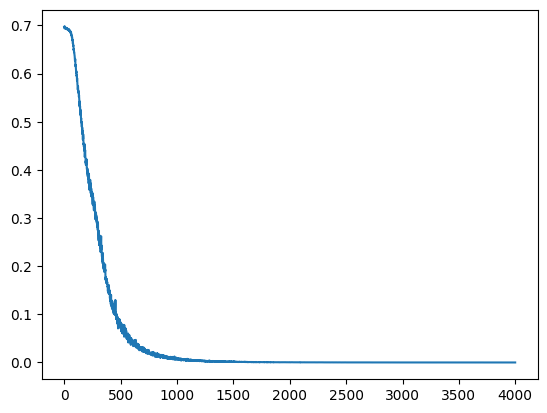

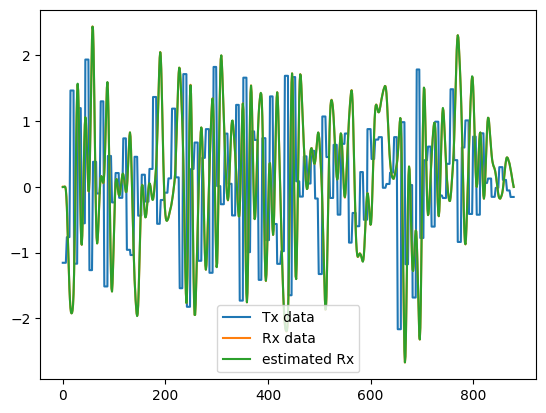

In [12]:
#=========== training the network  =========#
#----- prameters
episodes=4000
learning_rate=0.0008


in_features=N+guard_length
hidden_features=(nsymb)*OvrSmpRatio
out_features=in_features


#----- model
net=AEC_net(in_features, hidden_features, OvrSmpRatio)
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.NAdam(net.parameters(), lr=learning_rate)

#----- training
loss_log=[]
for e in range(episodes):
    optimizer.zero_grad()
    inp=generate_data(N,batch_size)
    data_pad = np.append(inp, np.zeros((batch_size,1,guard_length)), axis=2)
    data_pad = torch.from_numpy(data_pad).float()
    pred,a,x,xr=net.forward(data_pad)
    loss = loss_fn(pred[:,:,0:inp.shape[2]], inp)
    loss_log.append(loss.item())
    loss.backward()
    optimizer.step()
    if e%1000==0:
        learning_rate*=.3
        optimizer = torch.optim.NAdam(net.parameters(), lr=learning_rate)
        print(e)

plt.figure()
plt.plot(loss_log)
print(loss_log[-1])

plt.figure()
plt.plot(a[0,:].detach().numpy())
plt.plot(xr[0,0,:].detach().numpy())
plt.plot(x[0,0,:].detach().numpy())
plt.legend(['Tx data','Rx data','estimated Rx'])

# **Plot transmitted and received signals**

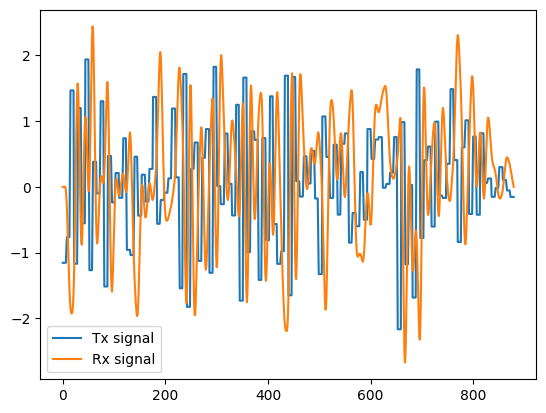

In [14]:
# --- plot trasmitted signal
plt.figure()
plt.plot(a[0,:].detach().numpy())
# for i in range(1,nsymb+1):
#   plt.axvline(x =i*OvrSmpRatio-1 , color = 'r', label = 'axvline - full height')


# --- plot received signal
plt.plot(x[0,0,:].detach().numpy())
plt.legend(['Tx signal','Rx signal'])



### ***Calculate BER***

In [16]:
#=========== evaluation on real system  =========#
SNR = 20
NoiseVar = 10 ** ((-SNR ) / 10)
lh=[]
batch_size=40
for j in range(100):
    inp=generate_data(N,batch_size)
    data_pad = np.append(inp, np.zeros((batch_size,1,guard_length)), axis=2)
    data_pad = torch.from_numpy(data_pad).float()
    op,xa,xr,a,y,b=net.predict(data_pad)
    lh.append(torch.mean((inp-op[:,:,0:inp.shape[2]])**2).item())

print('BER:',sum(lh)/len(lh))


BER: 0.0
